In [1]:
from datasets import load_dataset
from fastai.vision.all import *
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
# from concept_helpers.concept_deepview import DeepViewConcept
# from xplique.concepts import CraftTorch as Craft
from concept_helpers.DeepView_Craft import CraftTorchDV as Craft
from concept_helpers.DeepView_Craft import CraftTorchSupervisedShared as CraftSS
from concept_helpers.DeepView_Craft import CraftTorchSupervised as CraftS
from concept_helpers.combined_crafts import CombinedCrafts , CraftSAE
from xplique.attributions.global_sensitivity_analysis import HaltonSequenceRS, JansenEstimator

from xplique.concepts.craft_torch import _batch_inference

import urllib.request
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import timm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse.linalg import eigs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, adjusted_rand_score, rand_score,
                            normalized_mutual_info_score, adjusted_mutual_info_score)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from concept_helpers.disc_nmf import RSNMF

from sklearn.cluster import KMeans
import random
import torchvision.transforms.functional as F
import random
from DriftLocalization.j_helper_functions import uncertainty_matrices, entropy_uncertainty

from experiment_helpers.experiment_helper_functions import *

# from deepview.evaluate import evaluate_umap
# from deepview.evaluate import leave_one_out_knn_dist_err


device = 'cuda' 
# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.to(device)
# train_images, train_labels, val_images, val_labels, model = load_imagenette()

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in twop arts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
# g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
# h = nn.Sequential(*(list(model.children())[4:]))  # penultimate layer to logits

g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
# h = nn.Sequential(*(list(model.children())[4:]))
classifier_head = ClassifierHead(in_features=2048, out_features=10)
classifier_head = classifier_head.to(device)
classifier_head.load_state_dict(torch.load("models/imagewoof_classifier_head.pth"))

with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
    imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))


def gen_images(filelist):
    for f in filelist:
        folder_name = f.split('/')[-2]
        class_id = folder_name2class_id[folder_name]
        im = Image.open(f)
        if len(im.getbands()) == 3:
            yield np.array(im.resize((224, 224))), class_id
# Load imagenette dataset
imagewoof_folder = untar_data(URLs.IMAGEWOOF_160)

folders_names = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601',
                 'n02105641', 'n02111889', 'n02115641']

imagewoof_class_ids = list(range(0, 10))
folder_name2class_id = dict(zip(folders_names, imagewoof_class_ids))

# Get file lists for train, val, and test sets
# train_filelist = glob.glob(f'{imagewoof_folder}/train/*/*.JPEG')
val_filelist = glob.glob(f'{imagewoof_folder}/val/*/*.JPEG')
# test_filelist = glob.glob(f'{imagenette_folder}/test/*/*.JPEG')

# Preprocess train, validation, and test sets in batches
# train_images, train_labels = preprocess_images_in_batches(train_filelist)
val_images, val_labels = preprocess_images_in_batches(val_filelist,gen_images, transform, to_pil)

def gen_images(filelist,folder_names,folder_name2class_id):
        for f in filelist:
            
            folder_name = f.split('/')[-2]
            if folder_name in folder_names:
                class_id = folder_name2class_id[folder_name]
                im = Image.open(f)
                if len(im.getbands()) == 3:
                    yield np.array(im.resize((224, 224))), class_id

# ood_folder = '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
# # ood_folder = '/home/iroberts/projects/concepts_deepview/data/NINCO_all/NINCO/NINCO_popular_datasets_subsamples'

# ood_folder_names = ['french_fries','donuts','waffles','glass_of_milk','cup_cakes','chicken_quesadilla']#, 'donuts'] #'grey_fox', 'Arctic_fox']
# ood_class_names = ['french_fries','donuts','waffles','glass_of_milk','cup_cakes','chicken_quesadilla']#, 'donuts'] #'grey fox', 'Arctic fox']

ood_folder = '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
        
ood_folder_names = os.listdir(ood_folder)
ood_class_names = ood_folder_names

ood_class_ids = [i+1000 for i,class_name in enumerate(ood_class_names)]
ood_folder_name2class_id = dict(zip(ood_folder_names, ood_class_ids))
ood_filelist = glob.glob(f'{ood_folder}/*/*.jpg')
# print(ood_filelist)

ood_images, ood_labels = zip(*gen_images(ood_filelist,ood_folder_names,ood_folder_name2class_id))
ood_images, ood_labels = np.array(ood_images), np.array(ood_labels)
ood_preprocessed_images = torch.stack([transform(to_pil(img)) for img in ood_images], 0)

def full_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor)
        pred = h(latent).cpu().numpy()
    return pred
def latent_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor).cpu().numpy()
            # pred = h(tensor).cpu().numpy()
    return latent

def process_in_batches(data, batch_size, func):
    """
    Process data in batches using the full_wrapper function.

    Args:
        data (np.ndarray): Input data to process.
        batch_size (int): Size of each batch.

    Returns:
        np.ndarray: Predictions for the entire dataset.
    """
    # Initialize an empty list to store predictions
    all_preds = []

    # Iterate over the data in batches
    for start_idx in range(0, len(data), batch_size):
        # Get the end index for the current batch
        end_idx = min(start_idx + batch_size, len(data))
        # Get the current batch
        batch = data[start_idx:end_idx]
        # Use full_wrapper to process the batch and get predictions
        batch_preds = func(batch)
        # Append the predictions to the list
        all_preds.append(batch_preds)

    # Concatenate all batch predictions into a single numpy array
    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds
    
def predict_with_uncertainty_batched(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs,_ in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)

from sklearn.decomposition import non_negative_factorization


def predict_with_uncertainty_batched_sig(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)
    

def compute_predictions_sigmoid(inputs):
    # tree_predictions = []
    # for tree in model.estimators_:
    #     tree_predictions.append(tree.predict_proba(inputs))
    
    # tree_predictions = np.array(tree_predictions)
    
    # embeddings = process_in_batches(preprocessed_images,32, latent_wrapper,g).to(device)
    inputs = inputs.to(device)
    data_loader = torch.utils.data.DataLoader(inputs, batch_size=64)
    
    predictions = predict_with_uncertainty_batched_sig(stochastic_model, data_loader, n_iter=20, device=device)

    predictions =  predictions.cpu().numpy()
    
    a,prob_mat = uncertainty_matrices(predictions)
    t,e,a = entropy_uncertainty(prob_mat)
    sig_threshold, _, t_norm = get_threshold(t)
    loc = UncertaintyWrapperWithSigmoid(sig_threshold)

    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    return unc_preds, unc_pred_probs

def activation_transform(inputs, patches=False, labels=None, activations=None, n_patches=16):
    """
    Transforms the input images into an (N, 320) representation where N is the number of images.
    
    Parameters:
    - inputs: Input images or data to be transformed.
    - patches: Whether to use patches (if needed for some other functionality).
    - labels: Optional labels for the inputs.
    - activations: Optional pre-computed activations. If None, activations are computed.
    - drift_basis: Predefined basis for NMF.
    - n_patches: Number of patches per image (default is 16).
    
    Returns:
    - transformed_data: Transformed dataset with shape (N, 320).
    """
    
    # Step 1: Extract latent activations using drift_craft
    A = inputs#drift_craft._latent_predict(inputs)  # Assuming A.shape = (N, H, W, D) where D is the activation dimension
    # print(A.shape)
    # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
    original_shape = A.shape[:-1]  # Keep original shape to reconstruct later
    re_activations = np.reshape(A, (-1, A.shape[-1]))
    # print(re_activations.shape)# Flatten to (N * H * W, D)
    # print(re_activations.shape)
    # Step 3: Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality
    
    embedding, basis, n_iter = non_negative_factorization(np.array(re_activations),
                                                          n_components=len(unc_basis),
                                                          init='custom',
                                                          update_H=False, solver='mu', H=unc_basis)

    embedding = np.reshape(embedding, (*original_shape, embedding.shape[-1]))
    # print(embedding.shape)
    
    # Step 4: Reshape the embedding back to the original shape (N, n_patches, n_components)
    # N = 1 # Number of images
    # n_components = embedding.shape[-1]  # Number of concepts (after NMF reduction)
    
    # embedding_reshaped = np.reshape(embedding, (N, n_patches, n_components))  # Reshape back to (N, n_patches, n_components)
    
    # # Step 5: Tile the concepts for each patch to create (N, 320) dataset
    # # Since we need 320 dimensions (n_patches * n_components), we flatten the patches and their concepts
    # transformed_data = embedding_reshaped.reshape(N, -1)  # Shape (N, n_patches * n_components), e.g. (N, 320)

    return embedding
    
def estimate_importance_helper_sigmoid(inputs: np.ndarray = None, class_of_interest: int = None,
                                     nb_design: int = 32, compute_class_importance: bool = False) -> np.ndarray:
        """
        Estimates the importance of each concept for a given class, either globally
        on the whole dataset provided in the fit() method (in this case, inputs shall
        be set to None), or locally on a specific input image.

        Parameters
        ----------
        inputs : numpy array or Tensor
            The input data on which to compute the importances.
            If None, then the inputs provided in the fit() method
            will be used (global importance of the whole dataset).
            Default is None.
        nb_design
            The number of design to use for the importance estimation. Default is 32.

        Returns
        -------
        importances
            The Sobol total index (importance score) for each concept.

        """
        
        coeffs_u = activation_transform(inputs.permute((0,2,3,1)).cpu().numpy())
        # print(coeffs_u.shape)
        # coeffs_u = sigmoidunc_craft.transform(inputs)
        

        masks = HaltonSequenceRS()(len(unc_basis), nb_design=nb_design)
        estimator = JansenEstimator()
        importances = []

        if len(coeffs_u.shape) == 4:
            # for coeff in coeffs_u:
            # apply a re-parameterization trick and use mask on all localization for a given
            # concept id to estimate sobol indices
            for coeff in coeffs_u:
                u_perturbated = masks[:, None, None, :] * coeff[None, :]

                a_perturbated = np.reshape(u_perturbated,
                                           (-1, coeff.shape[-1])) @ unc_basis
                # print("a_perturbed", a_perturbated.shape)
                a_perturbated = np.reshape(a_perturbated,
                                           (len(masks), coeffs_u.shape[1], coeffs_u.shape[2], -1))
                # print("a_perturbed-re", torch.from_numpy(a_perturbated).shape)

                # a_perturbated: (N, H, W, C)
                _,y_pred = compute_predictions_sigmoid(torch.from_numpy(a_perturbated).permute((0,3,1,2)))
                # print("preds",y_pred.shape)

                y_pred = y_pred[:, class_of_interest]
                
                stis = estimator(masks, y_pred, nb_design)

                importances.append(stis)
        
        importances = np.mean(importances, 0)

        # # Save the results of the computation if working on the whole dataset
        if compute_class_importance:
            most_important_concepts = np.argsort(importances)[::-1]
            sigmoidunc_craft.sensitivities[class_of_interest] = Sensitivity(importances, most_important_concepts,
                                                                     cmaps=plt.get_cmap('tab20b').colors + plt.get_cmap('Set3').colors) 

        return importances

def nmf_transform(inputs,drift_basis, patches=False, labels=None, activations=None, n_patches=16):
    """
    Transforms the input images into an (N, 320) representation where N is the number of images.
    
    Parameters:
    - inputs: Input images or data to be transformed.
    - patches: Whether to use patches (if needed for some other functionality).
    - labels: Optional labels for the inputs.
    - activations: Optional pre-computed activations. If None, activations are computed.
    - drift_basis: Predefined basis for NMF.
    - n_patches: Number of patches per image (default is 16).
    
    Returns:
    - transformed_data: Transformed dataset with shape (N, 320).
    """
   
    # Step 1: Extract latent activations using drift_craft
    A = np.mean(inputs, axis=(1,2))#drift_craft._latent_predict(inputs)  # Assuming A.shape = (N, H, W, D) where D is the activation dimension
    # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
   # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
    # original_shape = A.shape[:-1]  # Keep original shape to reconstruct later
    # re_activations = np.reshape(A, (-1, A.shape[-1]))
    # print(re_activations.shape)
    # Step 3: Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality
    embedding, basis, n_iter = non_negative_factorization(A,
                                                          n_components=len(drift_basis),
                                                          init='custom',
                                                          update_H=False, solver='mu', H=drift_basis)
    # print(embedding.shape)
    

    return embedding

import torchvision.transforms.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os


    
import torch
import torch.nn.functional as F
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os

# Gaussian noise function
def gaussian_noise(images, probability=0.5, mean=0, std=1.5):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        add_gaussian_noise(img,mean=mean,std=std) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask


def add_gaussian_noise(image, mean=0, std=1.5):
    noise = torch.randn_like(image) * std + mean
    return torch.clamp(image + noise, 0, 1)

# Salt-and-pepper noise function
def salt_n_pepper(images, probability=0.4, snp_prob=.4): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_salt_and_pepper(img, prob=snp_prob)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_salt_and_pepper(image, prob=0.4):
    mask = torch.rand_like(image[:1])  # Single channel mask
    image = torch.where(mask < prob / 2, torch.tensor(0.0, device=image.device), image)
    image = torch.where(mask > 1 - prob / 2, torch.tensor(1.0, device=image.device), image)
    return image

    # Blurring function
def motion_blurring(images, probability=0.5, kernel_size=None, sigma=None, 
             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27]):    
    if kernel_size is None:
        kernel_size = random.choice(possible_kernels)
    if sigma is None:
        sigma = np.random.randint(0, 100)

    # Create a mask
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply blurring
    noisy_images = torch.stack([
         add_motion_blur(img, kernel_size=kernel_size) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_motion_blur(image, kernel_size=27):
    kernel = torch.zeros((kernel_size, kernel_size), device=image.device)
    kernel[:, kernel_size // 2] = 1.0 / kernel_size
    kernel = kernel.expand(3, 1, kernel_size, kernel_size)
    return F.conv2d(image.unsqueeze(0), kernel, padding=kernel_size//2, groups=3).squeeze(0)

    
# Blurring function
def gaussian_blurring(images, probability=0.5, kernel_size=None, sigma=None, 
             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27]):    
    if kernel_size is None:
        kernel_size = random.choice(possible_kernels)
    if sigma is None:
        sigma = np.random.randint(0, 100)

    # Create a mask
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply blurring
    noisy_images = torch.stack([
        add_gaussian_blur(img, kernel_size=kernel_size, sigma=sigma) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_gaussian_blur(image, kernel_size=25, sigma=5):
    return TF.gaussian_blur(image, kernel_size, [sigma, sigma])


# fog noise function
def fog(images, probability=.25, fog_strength=0.85): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_fog(img, fog_strength=fog_strength)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_fog(image, fog_strength=0.85):
    fog = torch.ones_like(image)
    return torch.clamp(image * (1 - fog_strength) + fog * fog_strength, 0, 1)


def chromatic_aberration(images, probability=.25, shift=15): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_chromatic_aberration(img, shift=shift)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_chromatic_aberration(image, shift=25):
    r, g, b = image[0], image[1], image[2]
    r = torch.roll(r, shifts=shift, dims=0)
    b = torch.roll(b, shifts=-shift, dims=0)
    return torch.stack([r, g, b])


def radial_blurring(images, probability=.25, strength=15): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_radial_blur(img, strength=strength)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_radial_blur(image, strength=10):
    h, w = image.shape[1:]
    y, x = torch.meshgrid(torch.linspace(-1, 1, h, device=image.device), torch.linspace(-1, 1, w, device=image.device))
    mask = torch.sqrt(x**2 + y**2)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    blurred = add_gaussian_blur(image, 21, 10)
    return torch.clamp(image * (1 - strength * mask) + blurred * (strength * mask), 0, 1)


# Gaussian noise function
def raining(images, probability=0.5, streak_length=15, density=0.03):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        add_rain(img,streak_length=streak_length, density=density) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

def add_rain(image, streak_length=15, density=0.07):
    mask = torch.zeros_like(image, device=image.device)
    num_streaks = int(density * image.shape[1] * image.shape[2])
    for _ in range(num_streaks):
        x, y = torch.randint(0, image.shape[2], (1,)), torch.randint(0, image.shape[1], (1,))
        for i in range(streak_length):
            if y + i < image.shape[1]:
                mask[:, y + i, x] = 1.0
    return torch.clamp(image + mask * 0.2, 0, 1)



# Gaussian noise function
def occluding(images, probability=0.5, occlusion_size=0.5):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        apply_occlusion(img,occlusion_size=occlusion_size, mode="black") if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def apply_occlusion(image, occlusion_size=0.9, mode="black"):
    h, w = image.shape[1:]
    patch_size = int(min(h, w) * occlusion_size)
    x1, y1 = torch.randint(0, w - patch_size, (1,)), torch.randint(0, h - patch_size, (1,))
    occluded_image = image.clone()
    if mode == "black":
        occluded_image[:, y1:y1+patch_size, x1:x1+patch_size] = 0
    elif mode == "white":
        occluded_image[:, y1:y1+patch_size, x1:x1+patch_size] = 1
    return occluded_image



# Gaussian noise function
def wavy(images, probability=0.5, frequency=20, amplitude=15):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        apply_wavy_distortion(img,frequency=frequency, amplitude=amplitude) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

def apply_wavy_distortion(image, frequency=20, amplitude=15):
    """
    Applies a wavy distortion effect to an image using PyTorch.

    Parameters:
        image (torch.Tensor): Input image (C, H, W), values in range [0, 255].
        frequency (int): Controls the number of waves (higher = more waves).
        amplitude (int): The strength of the distortion.
    
    Returns:
        torch.Tensor: Image with wavy distortion applied.
    """
    c, h, w = image.shape  # Get image dimensions
    
    # Generate a sinusoidal wave pattern for vertical displacement
    wave = amplitude * torch.sin(torch.linspace(0, torch.pi * frequency, h, device=image.device))  # Shape: (H,)
    
    # Convert wave values to integer shifts
    wave = wave.round().to(torch.int32)  # Shape: (H,)
    
    # Create an index grid for pixel shifts
    x_grid = torch.arange(w, device=image.device).repeat(h, 1)  # Shape: (H, W)
    x_grid = (x_grid + wave[:, None]) % w  # Apply shift with wrapping
    
    # Expand for each color channel and gather pixels
    x_grid = x_grid.expand(c, h, w)  # Shape: (C, H, W)
    distorted_image = torch.gather(image, 2, x_grid)
    
    return distorted_image

# # Salt-and-pepper noise function
# def salt_n_pepper(images, probability=0.5, pepper_prob=0.2, salt_prob=0.2): 
#     iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

#     # Apply salt-and-pepper noise
#     noisy_images = torch.stack([
#         torch.where(torch.rand_like(img) < salt_prob, torch.tensor(1.0), 
#                     torch.where(torch.rand_like(img) < pepper_prob, torch.tensor(0.0), img))
#         if iid_noise_mask[i] else img
#         for i, img in enumerate(images)
#     ])
#     return noisy_images, iid_noise_mask

# # Gaussian noise function
# def gaussian_noise(images, probability=0.5, mean=0, std=0.2):
#     iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

#     # Apply Gaussian noise
#     noisy_images = torch.stack([
#         torch.clamp(img + (torch.randn_like(img) * std + mean), 0, 1) if iid_noise_mask[i] else img
#         for i, img in enumerate(images)
#     ])
#     return noisy_images, iid_noise_mask




2025-02-25 10:33:06.600113: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
from sklearn.mixture import GaussianMixture
noise_dict = {
    'blurred': 'Gaussian Blur', 
    'salt_n_pepper': 'Salt N Pepper Noise', 
'gaussian': 'Gaussian Noise',
'motion':'Motion Blur',
'radial': 'Radial Blur', 
    'wavy': 'Wavy Noise', 
}

518
Fitting Unsupervised Craft....
Fitting Craft....


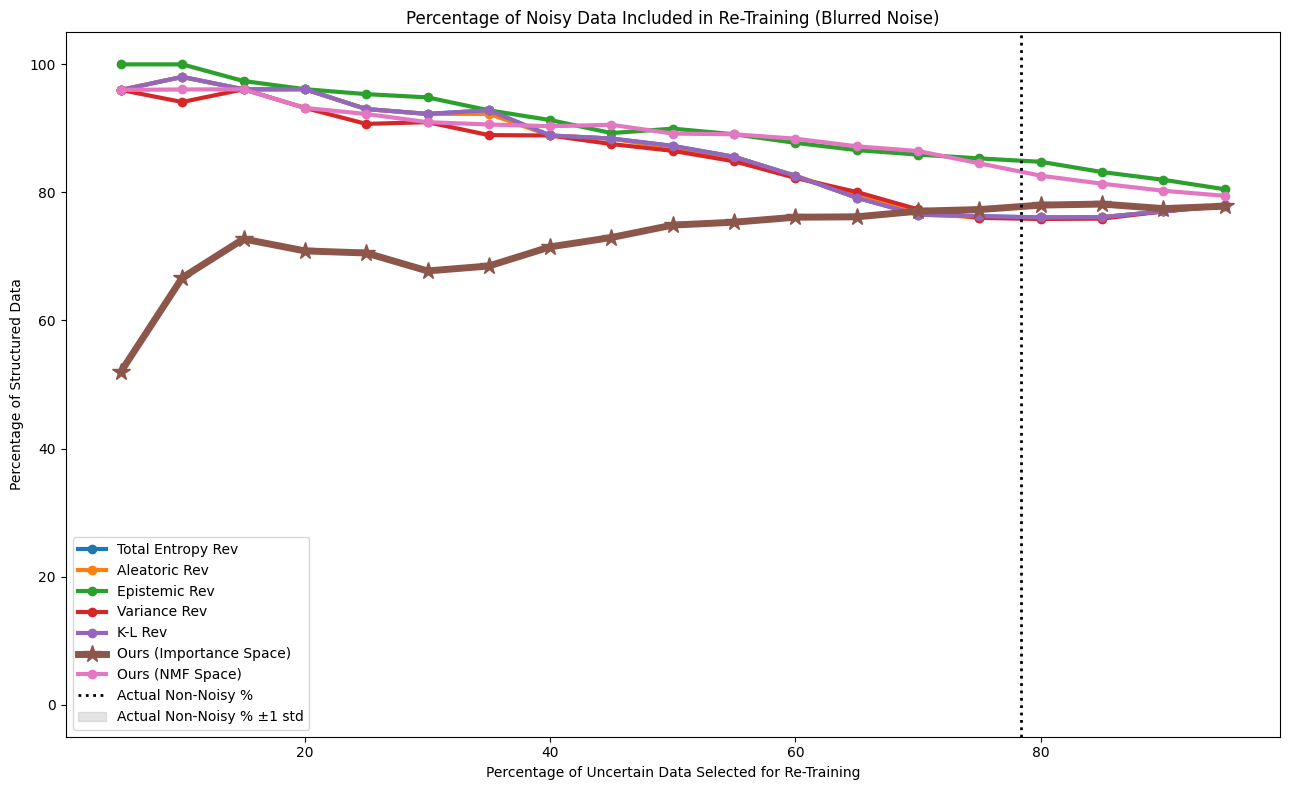

In [3]:
noise_types = ['blurred', 'salt_n_pepper', 'gaussian','motion','radial','chromatic','rain','occlusion','wavy','fog']

# Define k values
percentages = np.arange(5, 100, 5)
runs = 20  # Number of runs per noise type
prob_of_noise = .1

noise_types = ['blurred']#, 'salt_n_pepper', 'gaussian']
all_results = {noise: { "actual_percentage": [],
     "total_entropy_r": [], "aleatoric_r": [], "epistemic_r": [],
                        "var_r": [], "kl_r": [],
                       "sorted_imp_concepts_percentage": [], "sorted_nmf_concepts_percentage": []
} for noise in noise_types}

all_results_auc = {noise: {
    "total_entropy_r": [], "aleatoric_r": [], "epistemic_r": [],
                       "var_r": [], "kl_r": [],
                       "sorted_imp_concepts_percentage": [], "sorted_nmf_concepts_percentage": []
} for noise in noise_types}

# Run multiple times and collect results
for noise_type in noise_types:
    for _ in range(1):
    
    
        
        ood_sample = np.random.choice(len(ood_preprocessed_images),150,False)
        sample_ood_preprocessed_images = ood_preprocessed_images[ood_sample]
        sample_ood_labels = ood_labels[ood_sample]
        
        sample = np.random.choice(len(val_images),1000,False )
        sample_val_images = val_images[sample]
        sample_val_labels = val_labels[sample]
        
        
        
        # Assuming val_images is a batch of images (N, C, H, W)
        # Example: Create a random batch of images
        # val_images = torch.rand(8, 3, 256, 256)  # (Batch of 8 images)
        
        # Define parameters for Gaussian blur
        if noise_type == 'blurred':
           noisy_iid_images,iid_noise_mask = gaussian_blurring(sample_val_images, probability=prob_of_noise, kernel_size=21, sigma=10, 
                                                         possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27])
    
        if noise_type == 'salt_n_pepper':
            noisy_iid_images,iid_noise_mask = salt_n_pepper(sample_val_images, probability=prob_of_noise)
        
        
        if noise_type == 'gaussian':
            noisy_iid_images,iid_noise_mask = gaussian_noise(sample_val_images, probability=prob_of_noise, mean=0, std=1.5)
        if noise_type == 'motion':
            noisy_iid_images,iid_noise_mask = motion_blurring(sample_val_images, probability=prob_of_noise, kernel_size=27, sigma=10, 
                                                             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27])
        if noise_type == 'radial':
            noisy_iid_images,iid_noise_mask = radial_blurring(sample_val_images, probability=prob_of_noise, strength=15)
        if noise_type == 'chromatic':
            noisy_iid_images,iid_noise_mask = chromatic_aberration(sample_val_images, probability=prob_of_noise, shift=15)
        if noise_type == 'rain':
            noisy_iid_images,iid_noise_mask = raining(sample_val_images, probability=prob_of_noise, streak_length=15, density=0.07)
        if noise_type == 'occlusion':
            noisy_iid_images,iid_noise_mask = occluding(sample_val_images, probability=prob_of_noise, occlusion_size=.65)
        if noise_type == 'wavy':
            noisy_iid_images,iid_noise_mask = wavy(sample_val_images, probability=prob_of_noise, frequency=20, amplitude=15)
        if noise_type == 'fog':
            noisy_iid_images,iid_noise_mask = fog(sample_val_images, probability=prob_of_noise, fog_strength=0.99)

        # Step 3: Concatenate IID and OOD data
        idd_embeddings = process_in_batches(noisy_iid_images, 64, latent_wrapper)
        
        ood_embeddings = process_in_batches(sample_ood_preprocessed_images, 64, latent_wrapper)
        
        all_embeddings = torch.cat([torch.from_numpy(idd_embeddings),torch.from_numpy(ood_embeddings)]).to(device)
        all_images = torch.cat([noisy_iid_images, sample_ood_preprocessed_images]).to(device)
        all_labels = torch.from_numpy(np.concatenate([sample_val_labels, sample_ood_labels])).to(device)
        
        # Step 4: Create a full noise mask that extends to OOD images (which are never noisy)
        full_noise_mask = torch.cat([
            iid_noise_mask,  # This marks noisy IID images
            torch.zeros(sample_ood_preprocessed_images.shape[0], dtype=torch.bool)  # OOD images are never noisy
        ])
        
        # Step 5: Shuffle all data while keeping track of noise
        shuffle_indices = torch.randperm(all_images.shape[0])
        
        shuffled_embeddings = all_embeddings[shuffle_indices]
        shuffled_images = all_images[shuffle_indices]
        shuffled_labels = all_labels[shuffle_indices]
        shuffled_noise_mask = full_noise_mask[shuffle_indices]  # Tracks noisy images after shuffling
        
        idd_odd_og_labels = shuffled_labels.cpu().numpy()
        
        
        ood_ind = np.where(idd_odd_og_labels > 999)[0]
        idd_ind = np.where(idd_odd_og_labels <= 999)[0]
        
        idd_odd_labels = idd_odd_og_labels.copy()
        idd_odd_labels[ood_ind] = np.random.choice(np.unique(val_labels), size=len(ood_ind))
        gt_idd_ood = idd_odd_og_labels.copy()
        gt_idd_ood[ood_ind] = 1
        gt_idd_ood[idd_ind] = 0
        
        
        idd_odd_labels = torch.from_numpy(idd_odd_labels).to(device)
        dataset = EmbeddingDataset(shuffled_embeddings,idd_odd_labels)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
        
        # Create stochastic model
        dropout_prob = 0.5
        stochastic_model = StochasticModel(classifier_head, dropout_prob).to(device)
        
        
        predictions = predict_with_uncertainty_batched(stochastic_model.to(device), dataloader, n_iter=30)
        predictions = predictions.cpu().numpy()
        
        
        a, prob_mat = uncertainty_matrices(predictions)
        t, e, a = entropy_uncertainty(prob_mat)
       
        var = 1 -  np.mean(((np.full((prob_mat.shape[0],10),.1) - np.mean(prob_mat,axis=1))**2), axis=1)
                
        # kl = 1 - (kl_divergence(np.mean(prob_mat,axis=1), np.full((prob_mat.shape[0],10),.1),axis=1) / np.log(10))
               
        # threshold, _, t_norm = get_threshold(t)
        

        t_min, t_max = np.min(t), np.max(t)
        # Add a small epsilon to ensure values are strictly within (0, 1)
        epsilon = 1e-6
        t_normalized = (t - t_min) / (t_max - t_min)
        t_norm = np.clip(t_normalized, epsilon, 1 - epsilon)
        
        data = t_norm
        # Gaussian Mixture Model to estimate clusters
        gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
        data_reshaped = data.reshape(-1, 1)
        gmm.fit(data_reshaped)
        labels = gmm.predict(data_reshaped)
    
    
        cluster_data0 = data[labels == 0]
        cluster_data1 = data[labels == 1]
    
        if np.mean(cluster_data0) > np.mean(cluster_data1):
            mini = np.min(cluster_data0) 
            maxi = np.max(cluster_data1) 
            threshold = (mini + maxi) / 2
        if np.mean(cluster_data1) > np.mean(cluster_data0):
            mini = np.min(cluster_data1) 
            maxi = np.max(cluster_data0) 
            threshold = (mini + maxi) / 2        
        loc = UncertaintyWrapperWithSigmoid(threshold)
        unc_pred_probs = loc.predict_proba(t_norm)
        unc_preds = np.argmax(unc_pred_probs, axis=1)
        
        med_indices = np.where(unc_preds == 1)[0]
        print(len(med_indices))
        
        patch_size=80
        
        
        med_fit = Craft(input_to_latent_model=g,
                            latent_to_logit_model=classifier_head,
                            number_of_concepts=10,
                            # labels=h_y,
                            patch_size=patch_size,
                            batch_size=64,
                            device=device)
        print("Fitting Unsupervised Craft....")
        med_crops, med_crops_u, med_w = med_fit.fit(shuffled_images[med_indices])
        
        unc_basis = np.vstack([med_w])
        
        
        sigmoidunc_craft = CombinedCrafts(input_to_latent_model=g,
                        latent_to_logit_model=stochastic_model,
                        number_of_concepts=len(unc_basis),
                        inputs=shuffled_images[med_indices],
                        labels=unc_preds[med_indices],
                        basis = unc_basis,
                        batch_size=64,
                        patch_size=patch_size,
                        device=device)
        print("Fitting Craft....")
        sigmoidunc_craft.transform_all()

        data_groups = idd_odd_labels.cpu().numpy().copy()
        data_groups[ood_ind] = 2
        data_groups[idd_ind] = 0
        data_groups[np.where(shuffled_noise_mask == 1)[0]] = 1
        
        uncertain_groups = data_groups[np.where(unc_preds==1)[0]]
        struct_noisy_labels = uncertain_groups.copy()
        struct_noisy_labels[np.where(uncertain_groups == 1)[0]] = 0
        struct_noisy_labels[np.where(uncertain_groups != 1)[0]] = 1
        
        image_size = (shuffled_images[med_indices].shape[2], shuffled_images[med_indices].shape[3])
        height, width = image_size
        strides = int(sigmoidunc_craft.patch_size * 0.80)
        num_patches_per_image = ((height - sigmoidunc_craft.patch_size) // strides + 1) * ((width - sigmoidunc_craft.patch_size) // strides + 1)
                #
                # # Create a numpy array to store the label of each patch
        struct_noisy_patch_labels = np.repeat(struct_noisy_labels, num_patches_per_image)
        
        num_channels = shuffled_images[med_indices].shape[1]
        patches = torch.nn.functional.unfold(shuffled_images[med_indices], kernel_size=sigmoidunc_craft.patch_size, stride=strides)
        patches = patches.transpose(1, 2).contiguous().view(-1, num_channels, sigmoidunc_craft.patch_size, sigmoidunc_craft.patch_size)
        activations = sigmoidunc_craft._latent_predict(patches, resize=image_size)
        
        X_train, X_test, y_train, y_test = train_test_split(
            sigmoidunc_craft.factorization.crops_u, struct_noisy_patch_labels, test_size=0.33, random_state=42)
        
        
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        
        nb_crops = 20
        
        noisy_concepts = []
        for concept in range(10):
            best_crops_ids = np.argsort(sigmoidunc_craft.factorization.crops_u[:, concept])[::-1][:nb_crops]
            best_crops = np.array(sigmoidunc_craft.factorization.crops_u)[best_crops_ids]
            preds = clf.predict(best_crops)
            if sum(preds) <= .05 * nb_crops:
                noisy_concepts.append(concept)
        
        sig_im_imp = np.array([estimate_importance_helper_sigmoid(
            torch.unsqueeze(image,dim=0),class_of_interest=unc_preds[med_indices][i]) 
                               for i,image in enumerate(shuffled_embeddings[med_indices])])
        
        
        noisy_val_imp_list = []
        for i ,imp in enumerate(sig_im_imp):
            vals = imp[noisy_concepts]
            noisy_val_imp_list.append(vals.sum())
        sorted_noisy_imp_val_list = np.argsort(noisy_val_imp_list)
        
        
        sig_im_nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).permute((0,2,3,1)).cpu().numpy(),unc_basis) 
                                   for i,image in enumerate(shuffled_embeddings[med_indices])])
        sig_im_nmf_act =  sig_im_nmf_act.reshape((len(sig_im_nmf_act), sig_im_nmf_act.shape[2]))


        noisy_val_nmf_list = []
        for i ,imp in enumerate(sig_im_nmf_act):
            vals = imp[noisy_concepts]
            noisy_val_nmf_list.append(vals.sum())
        sorted_noisy_nmf_val_list = np.argsort(noisy_val_nmf_list)
                
        
        
        

        
        
        true_totals = []
        # noisy_percentage_baseline_total = []
        # noisy_percentage_baseline_a = []
        # noisy_percentage_baseline_e = []
        noisy_percentage_concepts = []
        noisy_percentage_top1_imp_concepts = []
        noisy_percentage_top1_nmf_concepts = []
        noisy_percentage_top2_imp_concepts = []
        noisy_percentage_top2_nmf_concepts = []
        noisy_percentage_top3_imp_concepts = []
        noisy_percentage_top3_nmf_concepts = []
        noisy_percentage_baseline_total_r = []
        noisy_percentage_baseline_a_r = []
        noisy_percentage_baseline_e_r = []
        # var_baseline = []
        # kl_baseline = []
        var_baseline_r = []
        kl_baseline_r = []
        for percent in percentages:
            k = int(percent * len(med_indices) / 100)  # Convert % to absolute count

            # true_total = np.round((struct_noisy_labels.sum() / len(struct_noisy_labels))*100,2)
            # true_totals.append(true_total)
            # baseline_var = np.round((struct_noisy_labels[np.argsort(var[med_indices])[::-1][:k]].sum() / k)*100,2)
            # var_baseline.append(baseline_var)
            
            baseline_var_r = np.round((struct_noisy_labels[np.argsort(var[med_indices])[:k]].sum() / k)*100,2)
            var_baseline_r.append(baseline_var_r)

            # baseline_kl = np.round((struct_noisy_labels[np.argsort(kl[med_indices])[::-1][:k]].sum() / k)*100,2)
            # kl_baseline.append(baseline_kl)
            
            # baseline_kl_r = np.round((struct_noisy_labels[np.argsort(kl[med_indices])[:k]].sum() / k)*100,2)
            # kl_baseline_r.append(baseline_kl_r)
            
            baseline_total_reversed = np.round((struct_noisy_labels[np.argsort(t[med_indices])[:k]].sum() / k)*100,2)
            noisy_percentage_baseline_total_r.append(baseline_total_reversed)
        
            baseline_a_reversed = np.round((struct_noisy_labels[np.argsort(a[med_indices])[:k]].sum() / k)*100,2)
            noisy_percentage_baseline_a_r.append(baseline_a_reversed)
        
            baseline_e_reversed = np.round((struct_noisy_labels[np.argsort(e[med_indices])[:k]].sum() / k)*100,2)
            noisy_percentage_baseline_e_r.append(baseline_e_reversed)
            
            # baseline_total = np.round((struct_noisy_labels[np.argsort(t[med_indices])[::-1][:k]].sum() / k)*100,2)
            # noisy_percentage_baseline_total.append(baseline_total)
        
            # baseline_a = np.round((struct_noisy_labels[np.argsort(a[med_indices])[::-1][:k]].sum() / k)*100,2)
            # noisy_percentage_baseline_a.append(baseline_a)
        
            # baseline_e = np.round((struct_noisy_labels[np.argsort(e[med_indices])[::-1][:k]].sum() / k)*100,2)
            # noisy_percentage_baseline_e.append(baseline_e)
        
            # concepts_percentage = np.round((struct_noisy_labels[label_id_list[:k]].sum() / k)*100,2)
            # noisy_percentage_concepts.append(concepts_percentage)
            
            sorted_noisy_imp_concepts_percentage = np.round((struct_noisy_labels[sorted_noisy_imp_val_list[:k]].sum() / k)*100,2)
            noisy_percentage_top1_imp_concepts.append(sorted_noisy_imp_concepts_percentage)
            
            sorted_noisy_nmf_concepts_percentage = np.round((struct_noisy_labels[sorted_noisy_nmf_val_list[:k]].sum() / k)*100,2)
            noisy_percentage_top1_nmf_concepts.append(sorted_noisy_nmf_concepts_percentage)

        true_total = np.round((1 - (struct_noisy_labels.sum() / len(struct_noisy_labels)))*100,2)
        true_totals.append(true_total)
        all_results[noise_type]["actual_percentage"].append(true_totals)    
        # all_results[noise_type]["total_entropy"].append(noisy_percentage_baseline_total)
        # all_results[noise_type]["aleatoric"].append(noisy_percentage_baseline_a)
        # all_results[noise_type]["epistemic"].append(noisy_percentage_baseline_e)
        all_results[noise_type]["total_entropy_r"].append(noisy_percentage_baseline_total_r)
        all_results[noise_type]["aleatoric_r"].append(noisy_percentage_baseline_a_r)
        all_results[noise_type]["epistemic_r"].append(noisy_percentage_baseline_e_r)
        # all_results[noise_type]["var"].append(var_baseline)
        all_results[noise_type]["var_r"].append(var_baseline_r)
        # all_results[noise_type]["kl"].append(kl_baseline)
        # all_results[noise_type]["kl_r"].append(kl_baseline_r)
        # all_results[noise_type]["concepts"].append(noisy_percentage_concepts)
        all_results[noise_type]["sorted_imp_concepts_percentage"].append(noisy_percentage_top1_imp_concepts)
        all_results[noise_type]["sorted_nmf_concepts_percentage"].append(noisy_percentage_top1_nmf_concepts)



figs_dir = "noise/second/figs"
csv_dir = "noise/second/csvs"
auc_dir = "noise/second/auc"
os.makedirs(figs_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)  # Directory for CSV files
os.makedirs(auc_dir, exist_ok=True)

for noise in noise_types:
    # Compute mean and standard deviation for each metric
    avg_results = {key: np.mean(np.array(values), axis=0) for key, values in all_results[noise].items()}
    std_results = {key: np.std(np.array(values), axis=0) for key, values in all_results[noise].items()}

    # Actual percentage of noisy points (mean and std)
    actual_noisy_percentage = avg_results["actual_percentage"]
    actual_noisy_std = std_results["actual_percentage"]

    # Create a new figure
    plt.figure(figsize=(13, 8))

    # Define method labels
    methods = {
        # "total_entropy": "Total Entropy",
        # "aleatoric": "Aleatoric",
        # "epistemic": "Epistemic",
        "total_entropy_r": "Total Entropy",
        "aleatoric_r": "Aleatoric",
        "epistemic_r": "Epistemic",
        # "var": "Variance",
        "var_r": "Variance",
        # "kl": "K-L",
        # "kl_r": "K-L",
        "sorted_imp_concepts_percentage": "Ours (Importance Space)",
        "sorted_nmf_concepts_percentage": "Ours (NMF Space)"
    }

    # Create a DataFrame to store CSV results
    csv_data = {"Method": []}

    for p in percentages:
        csv_data[f"{p}%"] = []

    for key, label in methods.items():
        mean_values = avg_results[key]
        std_values = std_results[key]

        # Apply small jitter to "Ours NMF" if it overlaps "Ours Importance"
        if key == "sorted_imp_concepts_percentage":
            plt.plot(percentages, mean_values, label=label, linewidth=5, marker="*",markersize=13)
        else: 
        # Plot with shaded standard deviation
            plt.plot(percentages, mean_values, label=label, linewidth=3, marker="o")
        plt.fill_between(percentages, mean_values - std_values, mean_values + std_values, alpha=0.2)

        # Save to CSV data
        csv_data["Method"].append(label)
        for i, p in enumerate(percentages):
            csv_data[f"{p}%"].append(mean_values[i])

    # Add horizontal dotted line for actual noisy percentage
    plt.axvline(100 - actual_noisy_percentage, color="black", linestyle="dotted", linewidth=2, label="Actual Non-Noisy %")

    # Shaded region for standard deviation of actual noisy percentage
    plt.fill_betweenx(
        y=[0, 40],  # Extend from bottom to top
        x1=100 - (actual_noisy_percentage + actual_noisy_std),
        x2=100 - (actual_noisy_percentage - actual_noisy_std),
        color="gray",
        alpha=0.2,
        label="Actual Non-Noisy % ±1 std"
    )

    # Formatting
    plt.xlabel("Percentage of Uncertain Data Selected for Re-Training")
    plt.ylabel("Percentage of Structured Data")
    plt.title(f"Percentage of Structured Data Included in Re-Training ({noise_dict[noise].capitalize()})")
    plt.legend()
    plt.tight_layout()

    # Save figure
    # fig_path = os.path.join(figs_dir, f"noisy_data_percentage_{noise}.png")
    # plt.savefig(fig_path, dpi=300)
    # plt.show()

    # # Save CSV file
    # csv_path = os.path.join(csv_dir, f"noisy_data_results_{noise}.csv")
    # df = pd.DataFrame(csv_data)
    # df.to_csv(csv_path, index=False)

for noise in noise_types:
    for method, res in all_results[noise].items():
        if method == 'actual_percentage':
            pass
        else:
            all_results_auc[noise][method].extend(np.trapz(res, percentages/100))
            
# auc_path = os.path.join(auc_dir, f"auc_results_{noise}.csv")
# auc_df = pd.DataFrame(all_results_auc)
# auc_df.to_csv(auc_path, index_label="method")


In [3]:
import pandas as pd 

df = pd.read_csv('/home/iroberts/projects/concepts_deepview/noise/second/auc/auc_results_occlusion.csv',index_col='method')

In [4]:
import ast
df_avg = df.applymap(lambda x: sum(ast.literal_eval(x)) / len(ast.literal_eval(x)))

/tmp/ipykernel_538721/2748449908.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_avg = df.applymap(lambda x: sum(ast.literal_eval(x)) / len(ast.literal_eval(x)))


In [5]:
df_avg

,occlusion
method,
total_entropy_r,11.842100
aleatoric_r,11.945525
epistemic_r,8.758825
var_r,12.338462
kl_r,11.842100
sorted_imp_concepts_percentage,8.838625
sorted_nmf_concepts_percentage,8.394875


In [152]:
all_results['gaussian']["actual_percentage"].append(true_totals)    
all_results['gaussian']["total_entropy"].append(noisy_percentage_baseline_total)
all_results['gaussian']["aleatoric"].append(noisy_percentage_baseline_a)
all_results['gaussian']["epistemic"].append(noisy_percentage_baseline_e)
all_results['gaussian']["total_entropy_r"].append(noisy_percentage_baseline_total_r)
all_results['gaussian']["aleatoric_r"].append(noisy_percentage_baseline_a_r)
all_results['gaussian']["epistemic_r"].append(noisy_percentage_baseline_e_r)
all_results['gaussian']["var"].append(var_baseline)
all_results['gaussian']["var_r"].append(var_baseline_r)
all_results['gaussian']["kl"].append(kl_baseline)
all_results['gaussian']["kl_r"].append(kl_baseline_r)
# all_results[noise_type]["concepts"].append(noisy_percentage_concepts)
all_results['gaussian']["sorted_imp_concepts_percentage"].append(noisy_percentage_top1_imp_concepts)
all_results['gaussian']["sorted_nmf_concepts_percentage"].append(noisy_percentage_top1_nmf_concepts)

In [153]:
all_results['blurred']["actual_percentage"].append(true_totals)    
all_results['blurred']["total_entropy"].append(noisy_percentage_baseline_total)
all_results['blurred']["aleatoric"].append(noisy_percentage_baseline_a)
all_results['blurred']["epistemic"].append(noisy_percentage_baseline_e)
all_results['blurred']["total_entropy_r"].append(noisy_percentage_baseline_total_r)
all_results['blurred']["aleatoric_r"].append(noisy_percentage_baseline_a_r)
all_results['blurred']["epistemic_r"].append(noisy_percentage_baseline_e_r)
all_results['blurred']["var"].append(var_baseline)
all_results['blurred']["var_r"].append(var_baseline_r)
all_results['blurred']["kl"].append(kl_baseline)
all_results['blurred']["kl_r"].append(kl_baseline_r)
# all_results[noise_type]["concepts"].append(noisy_percentage_concepts)
all_results['blurred']["sorted_imp_concepts_percentage"].append(noisy_percentage_top1_imp_concepts)
all_results['blurred']["sorted_nmf_concepts_percentage"].append(noisy_percentage_top1_nmf_concepts)

In [155]:
for noise in noise_types:
    for method, res in all_results[noise].items():
        if method == 'actual_percentage':
            pass
        else:
            all_results_auc[noise][method].extend(np.trapz(res, percentages/100))
        
            # for r in res:
                # all_results_auc[noise_type]["total_entropy"].append(noisy_percentage_baseline_total)
                # all_results_auc[noise_type]["aleatoric"].append(noisy_percentage_baseline_a)
                # all_results_auc[noise_type]["epistemic"].append(noisy_percentage_baseline_e)
                # all_results_auc[noise_type]["total_entropy_r"].append(noisy_percentage_baseline_total_r)
                # all_results_auc[noise_type]["aleatoric_r"].append(noisy_percentage_baseline_a_r)
                # all_results_auc[noise_type]["epistemic_r"].append(noisy_percentage_baseline_e_r)
                # all_results_auc[noise_type]["var"].append(var_baseline)
                # all_results_auc[noise_type]["var_r"].append(var_baseline_r)
                # all_results_auc[noise_type]["kl"].append(kl_baseline)
                # all_results_auc[noise_type]["kl_r"].append(kl_baseline_r)
                # # all_results[noise_type]["concepts"].append(noisy_percentage_concepts)
                # all_results_auc[noise_type]["sorted_imp_concepts_percentage"].append(noisy_percentage_top1_imp_concepts)
                # all_results_auc[noise_type]["sorted_nmf_concepts_percentage"].append(noisy_percentage_top1_nmf_concepts)
                # np.trapz(r, percentages/100))


In [157]:
import pandas as pd
pd.DataFrame(all_results_auc)

TypeError: DataFrame.__init__() got an unexpected keyword argument 'index_label'

In [13]:
  # top1_imp_id_list = []
        # for i ,imp in enumerate(sig_im_imp):
        #     if np.argmax(imp) not in noisy_concepts:
        #         top1_imp_id_list.append(i)
        #         top1_imp_id_list = []
        top1_nmf_id_list = []
        for i ,imp in enumerate(sig_im_nmf_act):
            if np.argmax(imp) not in noisy_concepts:
                top1_nmf_id_list.append(i)
                
        # top2_imp_id_list = []
        # for i, imp in enumerate(sig_im_imp):
        #     # Get indices of top 3 most important concepts
        #     top_2_concepts = np.argsort(imp)[-2:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_2_concepts):
        #         top2_imp_id_list.append(i)
        
        # top2_nmf_id_list = []
        # for i ,imp in enumerate(sig_im_nmf_act):
        #     # Get indices of top 3 most important concepts
        #     top_2_concepts = np.argsort(imp)[-2:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_2_concepts):
        #         top2_nmf_id_list.append(i)
        
        # top3_imp_id_list = []
        # for i, imp in enumerate(sig_im_imp):
        #     # Get indices of top 3 most important concepts
        #     top_3_concepts = np.argsort(imp)[-3:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_3_concepts):
        #         top3_imp_id_list.append(i)
        
        # top3_nmf_id_list = []
        # for i ,imp in enumerate(sig_im_nmf_act):
        #     # Get indices of top 3 most important concepts
        #     top_3_concepts = np.argsort(imp)[-3:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_3_concepts):
        #         top3_nmf_id_list.append(i)

label_id_list = []
        for i ,image in enumerate(shuffled_images[med_indices]):
            nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).cpu().numpy(),unc_basis) 
                                   for image in activations[i*num_patches_per_image:(i+1)* num_patches_per_image]])
            nmf_act =  nmf_act.reshape((len(nmf_act), nmf_act.shape[2]))
            preds = clf.predict(nmf_act)
            if sum(preds) < .95 * num_patches_per_image:
                label_id_list.append(i)

IndentationError: unexpected indent (2573058217.py, line 6)